In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

In [2]:
full_data = pd.read_csv("everything100percat.csv")


In [3]:
full_data.columns

Index(['Unnamed: 0', 'snapshot_ts', 'rev_id', 'timestamp', 'user', 'is_bot',
       'content', 'article_id', 'title', 'root', 'stratum', 'plain_text',
       'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness', 'upos_props',
       'mean_dep_depth', 'clause_ratio', 'voice_ratio', 'fre', 'fog',
       'chars_per_sent', 'sents_per_para', 'nTTR', 'word_density',
       'avg_line_len', 'citation_delta'],
      dtype='object')

In [4]:
# === Cell: Normalization utilities (place near your other utils) ===


def compute_baseline_stats(
        df: pd.DataFrame,
        feature_cols,
        category_col: str = 'root',
        timestamp_col: str = 'timestamp',
        baseline_end_date: str = '2022-11-01',
        min_baseline_rows_per_category: int = 10,
) -> pd.DataFrame:
    """
    Build per-category baseline means/std from rows strictly before baseline_end_date.
    Filters out categories with too few baseline rows to avoid junk std=0 artefacts.
    """
    # Ensure datetime
    if not np.issubdtype(df[timestamp_col].dtype, np.datetime64):
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=True, errors='coerce')

    baseline_df = df[df[timestamp_col] < pd.Timestamp(baseline_end_date, tz='UTC')].copy()

    # (Optional) guard: drop categories with too few baseline observations
    valid_cats = (
        baseline_df.groupby(category_col)[feature_cols[0]]
        .size()
        .loc[lambda s: s >= min_baseline_rows_per_category]
        .index
    )
    baseline_df = baseline_df[baseline_df[category_col].isin(valid_cats)]

    # Compute stats
    stats = baseline_df.groupby(category_col)[feature_cols].agg(['mean', 'std'])
    stats.columns = ['_'.join(col) for col in stats.columns]  # flatten
    return stats


def normalize_features_by_baseline(
        df: pd.DataFrame,
        feature_cols,
        baseline_stats: pd.DataFrame,
        category_col: str = 'root'
) -> pd.DataFrame:
    """
    Merge precomputed baseline stats and add <feature>_zscore columns.
    Categories without baseline end up with 0 z-scores to avoid NaNs in voting.
    """
    out = df.merge(baseline_stats, on=category_col, how='left')

    for col in feature_cols:
        mean_col = f'{col}_mean'
        std_col = f'{col}_std'
        z_col = f'{col}_zscore'

        mean_vals = out[mean_col]
        std_vals = out[std_col]

        # (value - mean)/std, safe divide; if no stats or std=0 → 0.0
        out[z_col] = np.divide(
            out[col] - mean_vals,
            std_vals,
            out=np.zeros(len(out), dtype=float),
            where=(std_vals.notna() & (std_vals != 0))
        )

    # drop the merged mean/std columns
    out.drop(columns=[c for c in out.columns if any(c.endswith(sfx) for sfx in ('_mean', '_std'))], inplace=True)
    return out


def load_or_build_baseline(
        df: pd.DataFrame,
        feature_cols,
        category_col: str = 'root',
        timestamp_col: str = 'timestamp',
        baseline_end_date: str = '2022-11-01',
        cache_path: str | Path = './_baseline_stats.pkl',
        min_baseline_rows_per_category: int = 10,
) -> pd.DataFrame:
    """
    Try to load baseline stats from disk; otherwise compute and cache.
    """
    cache_path = Path(cache_path)
    if cache_path.exists():
        with open(cache_path, 'rb') as f:
            stats = pickle.load(f)
    else:
        stats = compute_baseline_stats(
            df=df,
            feature_cols=feature_cols,
            category_col=category_col,
            timestamp_col=timestamp_col,
            baseline_end_date=baseline_end_date,
            min_baseline_rows_per_category=min_baseline_rows_per_category,
        )
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        with open(cache_path, 'wb') as f:
            pickle.dump(stats, f)
    return stats


In [5]:
# === Cell: Normalize current feature set ===

# Which features to normalize (extend to your full list of 14)
FEATURES_TO_NORMALIZE = [
    "p_t",
    "lexical_spike_delta",
    "perplexity",
    "burstiness",
    "mean_dep_depth",
    "clause_ratio",
    "voice_ratio",
    "fre",
    "fog",
    "chars_per_sent",
    "sents_per_para",
    "avg_line_len",
    "nTTR",
    "word_density",
    "citation_delta"
]

BASELINE_END = '2022-11-01'  # end of pre-ChatGPT window

# 1) Build/load per-category baseline stats once
baseline_stats = load_or_build_baseline(
    df=full_data,
    feature_cols=FEATURES_TO_NORMALIZE,
    category_col='root',
    timestamp_col='timestamp',
    baseline_end_date=BASELINE_END,
    cache_path='./_baseline_stats.pkl',
    min_baseline_rows_per_category=10,
)

# 2) Produce z-scores for the whole panel (pre and post)
features_df_z = normalize_features_by_baseline(
    df=full_data,
    feature_cols=FEATURES_TO_NORMALIZE,
    baseline_stats=baseline_stats,
    category_col='root',
)

# 3) (Optional) keep only z-score views for voting
Z_FEATURES = [f'{c}_zscore' for c in FEATURES_TO_NORMALIZE]
features_for_voting = features_df_z[['timestamp', 'root', 'title', 'rev_id', 'ai_flag'] + Z_FEATURES].copy() \
    if all(c in features_df_z.columns for c in ['title', 'rev_id', 'ai_flag']) \
    else features_df_z[['timestamp', 'root'] + Z_FEATURES].copy()


In [6]:
features_df_z.columns

Index(['Unnamed: 0', 'snapshot_ts', 'rev_id', 'timestamp', 'user', 'is_bot',
       'content', 'article_id', 'title', 'root', 'stratum', 'plain_text',
       'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness', 'upos_props',
       'mean_dep_depth', 'clause_ratio', 'voice_ratio', 'fre', 'fog',
       'chars_per_sent', 'sents_per_para', 'nTTR', 'word_density',
       'avg_line_len', 'citation_delta', 'p_t_zscore',
       'lexical_spike_delta_zscore', 'perplexity_zscore', 'burstiness_zscore',
       'mean_dep_depth_zscore', 'clause_ratio_zscore', 'voice_ratio_zscore',
       'fre_zscore', 'fog_zscore', 'chars_per_sent_zscore',
       'sents_per_para_zscore', 'avg_line_len_zscore', 'nTTR_zscore',
       'word_density_zscore', 'citation_delta_zscore'],
      dtype='object')

In [7]:
# You can easily experiment with these two parameters now.
Z_SCORE_THRESHOLD = 2.5
MINIMUM_VOTES = 4 # e.g., flag if at least 4 out of 15 features are anomalous

In [8]:
import pandas as pd
import numpy as np

# Assume 'features_df_z' is the DataFrame that has been processed by your
# normalize_features_by_baseline() function.

# --- 1. Define the CORRECT list of z-score columns to be used in the voting system ---
# This list now matches the 15 features present in your DataFrame.
zscore_cols = [
    'p_t_zscore',
    'lexical_spike_delta_zscore',
    'perplexity_zscore',
    'burstiness_zscore',
    'mean_dep_depth_zscore',
    'clause_ratio_zscore',
    'voice_ratio_zscore',
    'fre_zscore',
    'fog_zscore',
    'chars_per_sent_zscore',
    'sents_per_para_zscore',
    'nTTR_zscore',
    'word_density_zscore',
    'avg_line_len_zscore',
    'citation_delta_zscore'
]

# --- 2. Define the new voting system function based on a Z-Score Cutoff ---
def apply_voting_system_zscore(df, z_score_cutoff=2.5, min_votes=3):
    """
    Applies a voting system to flag revisions based on a z-score cutoff.

    A "vote" is cast for a revision if the absolute value of a feature's
    z-score exceeds the specified cutoff.

    Args:
        df (pd.DataFrame): The DataFrame containing the z-score columns.
        z_score_cutoff (float): The z-score value to use as a threshold.
        min_votes (int): The minimum number of votes required to flag a
                         revision as potentially AI-generated.

    Returns:
        pd.DataFrame: The input DataFrame with two new columns:
                      'ai_vote_count' and 'ai_flag'.
    """
    print(f"Applying voting system with Z-Score cutoff: {z_score_cutoff} and minimum votes: {min_votes}")

    # Calculate the number of votes for each revision.
    # A vote is cast if the absolute z-score is > cutoff.
    # We use abs() because a very low score (e.g., perplexity) can be as
    # anomalous as a very high score (e.g., nTTR).
    df['ai_vote_count'] = df[zscore_cols].abs().gt(z_score_cutoff).sum(axis=1)

    # Flag the revision if the vote count meets the minimum threshold
    df['ai_flag'] = df['ai_vote_count'] >= min_votes

    print("Voting system application complete.")
    return df

# --- 3. Apply the new voting system --- moved outside for convenience
# # You can easily experiment with these two parameters now.
# Z_SCORE_THRESHOLD = 2.5
# MINIMUM_VOTES = 2 # e.g., flag if at least 4 out of 15 features are anomalous

final_df = apply_voting_system_zscore(
    features_df_z,
    z_score_cutoff=Z_SCORE_THRESHOLD,
    min_votes=MINIMUM_VOTES
)

# --- 4. Display the results ---
print("\n--- Voting System Results ---")
print(final_df[['rev_id', 'timestamp', 'root', 'ai_vote_count', 'ai_flag']].head())

print("\n--- Distribution of Votes ---")
print(final_df['ai_vote_count'].value_counts().sort_index())

# Calculate and display the total number of flagged revisions
flagged_count = final_df['ai_flag'].sum()
total_count = len(final_df)
print(f"\nTotal revisions flagged as potentially AI-generated: {flagged_count} out of {total_count} ({flagged_count/total_count:.2%})")


Applying voting system with Z-Score cutoff: 2.5 and minimum votes: 4
Voting system application complete.

--- Voting System Results ---
       rev_id                  timestamp     root  ai_vote_count  ai_flag
0  1160763005  2023-06-18 16:30:41+00:00  History              3    False
1  1166013433  2023-07-18 21:17:52+00:00  History              3    False
2  1171485250  2023-08-21 11:13:21+00:00  History              3    False
3  1177319025  2023-09-27 04:45:15+00:00  History              3    False
4  1181899435  2023-10-25 22:06:39+00:00  History              3    False

--- Distribution of Votes ---
ai_vote_count
0    12009
1     1935
2     1275
3      362
4      123
5       78
6       46
7        3
9        1
Name: count, dtype: int64

Total revisions flagged as potentially AI-generated: 251 out of 15832 (1.59%)


In [9]:
final_df

,Unnamed: 0,snapshot_ts,rev_id,timestamp,user,is_bot,content,article_id,title,root,...,fre_zscore,fog_zscore,chars_per_sent_zscore,sents_per_para_zscore,avg_line_len_zscore,nTTR_zscore,word_density_zscore,citation_delta_zscore,ai_vote_count,ai_flag
0,0,2023-06-30 00:00:00+00:00,1160763005,2023-06-18 16:30:41+00:00,2601:483:C301:7360:BC05:287F:176:F15F,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,-4.327842,6.045270,0.543670,-0.965933,-0.837440,-0.782697,0.110041,-1.315955,3,False
1,1,2023-07-31 00:00:00+00:00,1166013433,2023-07-18 21:17:52+00:00,TompaDompa,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,-4.281436,5.973193,0.464213,-0.958110,-0.840029,-0.698040,0.122510,-1.313476,3,False
2,2,2023-08-31 00:00:00+00:00,1171485250,2023-08-21 11:13:21+00:00,79.41.96.200,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,-4.326513,6.034735,0.475988,-0.958110,-0.837633,-0.698040,0.116385,-1.315791,3,False
3,3,2023-09-30 00:00:00+00:00,1177319025,2023-09-27 04:45:15+00:00,187.254.98.237,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,-4.309285,6.021318,0.543078,-0.965933,-0.837556,-0.698040,0.116189,-1.246176,3,False
4,4,2023-10-31 00:00:00+00:00,1181899435,2023-10-25 22:06:39+00:00,Idulatria,False,{{Use dmy dates|date=July 2021}}\n{{Short desc...,20951,List of empires,History,...,-4.323714,6.039556,0.476368,-0.958110,-0.837556,-0.698040,0.116189,-1.246176,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15827,15827,2023-12-31 00:00:00+00:00,1190712502,2023-12-19 11:44:12+00:00,Mika1h,False,{{more citations needed|date=April 2023}}\n{{I...,8654,Pac-Man All-Stars,Video games,...,-0.338468,-1.103966,-1.121026,-0.807131,-0.983865,1.306311,3.336936,0.040132,2,False
15828,15828,2024-01-31 00:00:00+00:00,1197552616,2024-01-21 00:52:22+00:00,Venky64,False,{{more citations needed|date=April 2023}}\n{{I...,8654,Pac-Man All-Stars,Video games,...,-0.353607,-1.112477,-1.147850,-0.807131,-0.986427,0.998153,3.260247,0.033969,1,False
15829,15829,2023-08-31 00:00:00+00:00,1172064757,2023-08-24 18:34:01+00:00,CurlyWi,False,{{Infobox video game\n| collapsible = \n| ital...,10527,Idol Showdown,Video games,...,0.133137,-1.828332,-0.920569,-0.558323,-0.754252,-0.533352,0.632742,-0.545341,0,False
15830,15830,2023-10-31 00:00:00+00:00,1181427482,2023-10-23 00:04:28+00:00,Radja Dwm,False,{{Infobox video game\n| collapsible = \n| ital...,10527,Idol Showdown,Video games,...,-0.036570,-1.441546,-0.863354,-0.500906,-0.694054,-0.279023,0.431931,-0.763382,0,False


In [10]:
# how many entries that have vote = True and have perplexity as None
perplexityNoneAndAI = final_df[final_df['ai_flag'] == True].loc[final_df['perplexity'].isnull()].shape[0]
countAiFlag = final_df[final_df['ai_flag'] == True].shape[0]
print(f"perplexityNoneAndAI: {perplexityNoneAndAI}")
print(f"aiFlag:{countAiFlag}")
print(f"total_count: {total_count}")




perplexityNoneAndAI: 13
aiFlag:251
total_count: 15832


In [11]:
# save to a file called normalized_everything100percat_with_ai_votes.csv
final_df.to_csv("normalized_everything100percat_with_ai_votes.csv", index=False)

In [12]:
final_df = pd.read_csv("normalized_everything100percat_with_ai_votes.csv")

In [13]:
import pandas as pd
import numpy as np

# Assume 'features_df_z' is the DataFrame that has been processed by your
# normalize_features_by_baseline() function and contains all z-score columns.

# --- 1. Isolate the Baseline Data for Calibration ---
# We only want to test our parameters on the data we know should be "human".
baseline_end_date = '2022-11-01'
# Ensure timestamp column is in datetime format for comparison
features_df_z['timestamp'] = pd.to_datetime(features_df_z['timestamp'])
baseline_df = features_df_z[features_df_z['timestamp'] < baseline_end_date].copy()

print(f"Calibrating thresholds using {len(baseline_df)} baseline revisions (pre-{baseline_end_date}).")

# --- 2. Define the Grid of Parameters to Test ---
z_score_cutoffs = [2.0, 2.5, 3.0, 3.5]
min_votes_options = [2, 3, 4, 5, 6]

# The list of z-score columns to use for voting
zscore_cols = [col for col in features_df_z.columns if col.endswith('_zscore')]

# --- 3. Perform the Grid Search ---
results = []

for z_cutoff in z_score_cutoffs:
    row = {'z_score_cutoff': z_cutoff}
    for min_v in min_votes_options:
        # Calculate votes for the current parameter combination
        vote_count = baseline_df[zscore_cols].abs().gt(z_cutoff).sum(axis=1)

        # Determine the number of revisions flagged
        flagged_count = (vote_count >= min_v).sum()

        # Calculate the percentage of the baseline that was flagged (Baseline Flag Rate)
        baseline_flag_rate = (flagged_count / len(baseline_df)) * 100

        # Store the result, formatted as a percentage string
        row[f'min_votes_{min_v}'] = f"{baseline_flag_rate:.2f}%"

    results.append(row)

# --- 4. Display the Results in a Clear Table ---
calibration_results_df = pd.DataFrame(results).set_index('z_score_cutoff')

print("\n--- Calibration Results (Baseline Flag Rate %) ---")
print("This table shows the percentage of pre-ChatGPT revisions that would be flagged for each parameter combination.")
print(calibration_results_df)



Calibrating thresholds using 6118 baseline revisions (pre-2022-11-01).

--- Calibration Results (Baseline Flag Rate %) ---
This table shows the percentage of pre-ChatGPT revisions that would be flagged for each parameter combination.
               min_votes_2 min_votes_3 min_votes_4 min_votes_5 min_votes_6
z_score_cutoff                                                            
2.0                 19.81%       7.45%       3.24%       1.63%       0.74%
2.5                 10.95%       3.61%       1.81%       0.92%       0.33%
3.0                  5.72%       2.35%       1.00%       0.29%       0.15%
3.5                  3.60%       1.27%       0.51%       0.15%       0.13%


# Sanity Check
(check if normalization was done properly)


In [14]:
import pandas as pd
import numpy as np

def verify_wiki_normalization(
    normalized_df: pd.DataFrame,
    raw_feature: str,
    category_to_check: str,
    category_col: str = 'root',
    timestamp_col: str = 'timestamp',
    baseline_end_date: str = '2022-11-01'
):
    """
    Verifies the per-category, time-based z-score calculation for a single
    feature and a single category. This version uses a robust datetime check.

    Args:
        normalized_df (pd.DataFrame): The full DataFrame after normalization.
        raw_feature (str): The name of the raw feature to check (e.g., 'fre').
        category_to_check (str): The specific category to verify (e.g., 'History').
        category_col (str): The name of the category column.
        timestamp_col (str): The name of the timestamp column.
        baseline_end_date (str): The date defining the end of the baseline period.
    """
    zscore_feature = f"{raw_feature}_zscore"

    print(f"--- Verifying Z-Score for feature: '{raw_feature}' in Category: '{category_to_check}' ---")

    df = normalized_df.copy()

    # --- CORRECTED DATETIME CHECK ---
    # Use the pandas-native API for checking datetime types, which handles timezones correctly.
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        print(f"Converting '{timestamp_col}' to datetime...")
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=True, errors='coerce')

    # 1. Manually isolate the baseline data for THIS SPECIFIC CATEGORY
    baseline_df = df[
        (df[category_col] == category_to_check) &
        (df[timestamp_col] < pd.Timestamp(baseline_end_date, tz='UTC'))
    ]

    if len(baseline_df) < 2: # Need at least 2 points to calculate std dev
        print(f"Warning: Not enough baseline data ({len(baseline_df)} rows) found for '{category_to_check}' to verify. Skipping.")
        print("-" * 70)
        return

    # 2. Manually calculate the mean and std dev for this category's baseline
    baseline_mean = baseline_df[raw_feature].mean()
    baseline_std = baseline_df[raw_feature].std()

    print(f"Manual Baseline Calculation for '{category_to_check}':")
    print(f"  - Mean of '{raw_feature}': {baseline_mean:.6f}")
    print(f"  - Std Dev of '{raw_feature}': {baseline_std:.6f}\n")

    # 3. Manually compute the z-scores for ALL data in this category
    category_df = df[df[category_col] == category_to_check]

    if pd.notna(baseline_std) and baseline_std != 0:
        manually_computed_zscores = (category_df[raw_feature] - baseline_mean) / baseline_std
    else:
        # If std is 0 or NaN, the result should be 0, matching the function's logic
        manually_computed_zscores = pd.Series(0.0, index=category_df.index)

    manually_computed_zscores = manually_computed_zscores.fillna(0)

    # 4. Get the z-scores produced by your function for this category
    function_zscores = category_df[zscore_feature].fillna(0)

    # 5. Compare the two results
    are_they_equal = np.allclose(manually_computed_zscores, function_zscores)

    if are_they_equal:
        print(f"✅ SUCCESS: The function's z-scores for '{category_to_check}' match the manual calculation.")
    else:
        print(f"❌ FAILURE: The z-scores for '{category_to_check}' do not match.")
        diff_df = pd.DataFrame({
            'function_z': function_zscores,
            'manual_z': manually_computed_zscores,
            'difference': function_zscores - manually_computed_zscores
        })
        print("Showing first 5 rows with significant differences:")
        display(diff_df[diff_df['difference'].abs() > 1e-9].head())

    print("-" * 70)


# --- EXAMPLE USAGE ---
# Assumes 'final_wiki_df' is available in your notebook.

# Verify for a major category
verify_wiki_normalization(
    normalized_df=final_df,
    raw_feature='fre',
    category_to_check='History'
)

# Verify for another one
if 'Computing' in final_df['root'].unique():
    verify_wiki_normalization(
        normalized_df=final_df,
        raw_feature='perplexity',
        category_to_check='Computing'
    )


--- Verifying Z-Score for feature: 'fre' in Category: 'History' ---
Converting 'timestamp' to datetime...
Manual Baseline Calculation for 'History':
  - Mean of 'fre': 27.680064
  - Std Dev of 'fre': 19.238637

✅ SUCCESS: The function's z-scores for 'History' match the manual calculation.
----------------------------------------------------------------------
--- Verifying Z-Score for feature: 'perplexity' in Category: 'Computing' ---
Converting 'timestamp' to datetime...
Manual Baseline Calculation for 'Computing':
  - Mean of 'perplexity': 485.400160
  - Std Dev of 'perplexity': 276.798486

✅ SUCCESS: The function's z-scores for 'Computing' match the manual calculation.
----------------------------------------------------------------------


In [15]:
# unique values for root column
final_df['root'].unique()

array(['History', 'Politics', 'Technology', 'Computing', 'Biology',
       'Chemistry', 'Physics', 'Film', 'Music', 'Science', 'Engineering',
       'Elections', 'Political parties', 'Popular culture', 'Television',
       'Political history', 'History by country', 'Military history',
       'Medicine', 'Video games'], dtype=object)

--- Calculating Percentage Change for Lollipop Plot ---

--- Percentage Change in Mean Values (Full Data) ---


,feature,percentage_change
0,p_t,2.415648e+00
1,lexical_spike_delta,3.414034e+15
2,perplexity,-1.507730e+00
3,burstiness,2.447854e+00
4,mean_dep_depth,2.785205e-01
5,clause_ratio,1.032441e+00
6,voice_ratio,-5.391416e-02
7,fre,-1.218584e+00
8,fog,2.980297e-01
9,chars_per_sent,1.084049e+00



NOTE: The feature 'lexical_spike_delta' was excluded from the plot due to its extreme scale, but its value is reported above.


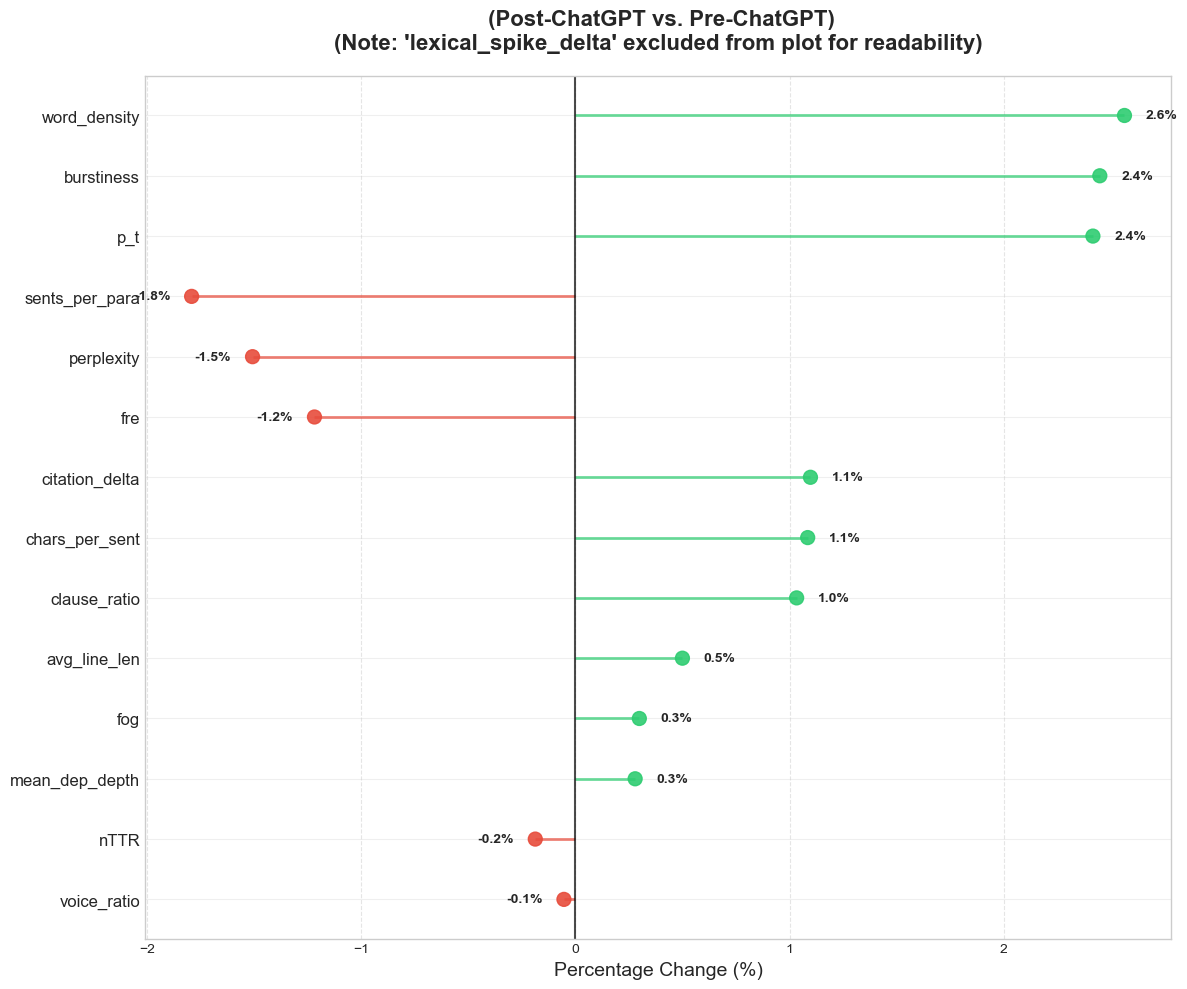

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_percentage_change_lollipop_corrected(df: pd.DataFrame, feature_cols: list[str], cutoff_date_str: str = '2022-11-01'):
    """
    Calculates and creates a diverging lollipop plot, robustly handling
    extreme outliers for a clear and readable visualization.

    Args:
        df (pd.DataFrame): The DataFrame containing the data and a timestamp column.
        feature_cols (list[str]): A list of the raw feature columns to analyze.
        cutoff_date_str (str): The date string to use as the cutoff point.
    """
    print("--- Calculating Percentage Change for Lollipop Plot ---")

    # --- 1. Data Preparation ---
    df_work = df.copy()
    df_work['timestamp'] = pd.to_datetime(df_work['timestamp'], utc=True, errors='coerce')

    cutoff_date = pd.Timestamp(cutoff_date_str, tz='UTC')
    pre_df = df_work[df_work['timestamp'] < cutoff_date]
    post_df = df_work[df_work['timestamp'] >= cutoff_date]

    # --- 2. Calculate Means and Percentage Change ---
    pre_means = pre_df[feature_cols].mean()
    post_means = post_df[feature_cols].mean()
    percentage_change = ((post_means - pre_means) / pre_means.abs()) * 100

    change_df = percentage_change.reset_index()
    change_df.columns = ['feature', 'percentage_change']

    print("\n--- Percentage Change in Mean Values (Full Data) ---")
    display(change_df)

    # --- 3. Prepare Data for Visualization (Handle Outlier) ---
    # Exclude the feature causing the extreme scale distortion from the plot
    outlier_feature = 'lexical_spike_delta'
    plot_df = change_df[change_df['feature'] != outlier_feature].copy()

    # Sort by the magnitude of change for a cleaner plot
    plot_df = plot_df.reindex(plot_df.percentage_change.abs().sort_values(ascending=False).index)

    print(f"\nNOTE: The feature '{outlier_feature}' was excluded from the plot due to its extreme scale, but its value is reported above.")

    # --- 4. Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))

    colors = ['#2ecc71' if x >= 0 else '#e74c3c' for x in plot_df['percentage_change']]

    ax.hlines(y=plot_df['feature'], xmin=0, xmax=plot_df['percentage_change'], color=colors, alpha=0.7, linewidth=2)
    ax.scatter(plot_df['percentage_change'], plot_df['feature'], color=colors, s=100, alpha=0.9, zorder=3)

    for i, row in plot_df.iterrows():
        change = row['percentage_change']
        ha = 'left' if change >= 0 else 'right'
        offset = 0.1 * np.sign(change) if change != 0 else 0.1
        ax.text(change + offset, row['feature'], f'{change:.1f}%',
                ha=ha, va='center', fontsize=10, weight='bold')

    title_text = (
        ' (Post-ChatGPT vs. Pre-ChatGPT)\n'
        f"(Note: '{outlier_feature}' excluded from plot for readability)"
    )
    ax.set_title(title_text, fontsize=16, weight='bold', pad=20)
    ax.set_xlabel('Percentage Change (%)', fontsize=14)
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    ax.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
raw_features_to_plot = [
    'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness', 'mean_dep_depth',
    'clause_ratio', 'voice_ratio', 'fre', 'fog', 'chars_per_sent',
    'sents_per_para', 'avg_line_len', 'nTTR', 'word_density', 'citation_delta'
]
existing_features = [f for f in raw_features_to_plot if f in final_df.columns]

plot_percentage_change_lollipop_corrected(final_df, existing_features)


--- Comparing Mean Feature Values: Pre- vs. Post-ChatGPT ---

--- Aggregated Mean Values ---


,period,p_t,lexical_spike_delta,perplexity,burstiness,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,avg_line_len,nTTR,word_density,citation_delta
0,Post-ChatGPT,0.022694,5.352817e-04,512.017471,0.672409,3.616321,0.847637,0.988803,28.660454,17.130122,194.687093,136.541075,23370.286905,7.010292,2.260990,0.012863
1,Pre-ChatGPT,0.022159,1.573926e-17,519.855488,0.656343,3.606277,0.838975,0.989336,29.014014,17.079221,192.599223,139.032690,23254.198104,7.023478,2.204489,0.012724


C:\Users\david\AppData\Local\Temp\ipykernel_26652\3915189400.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\david\AppData\Local\Temp\ipykernel_26652\3915189400.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\david\AppData\Local\Temp\ipykernel_26652\3915189400.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\david\AppData\Local\Temp\ipykernel_26652\3915189400.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

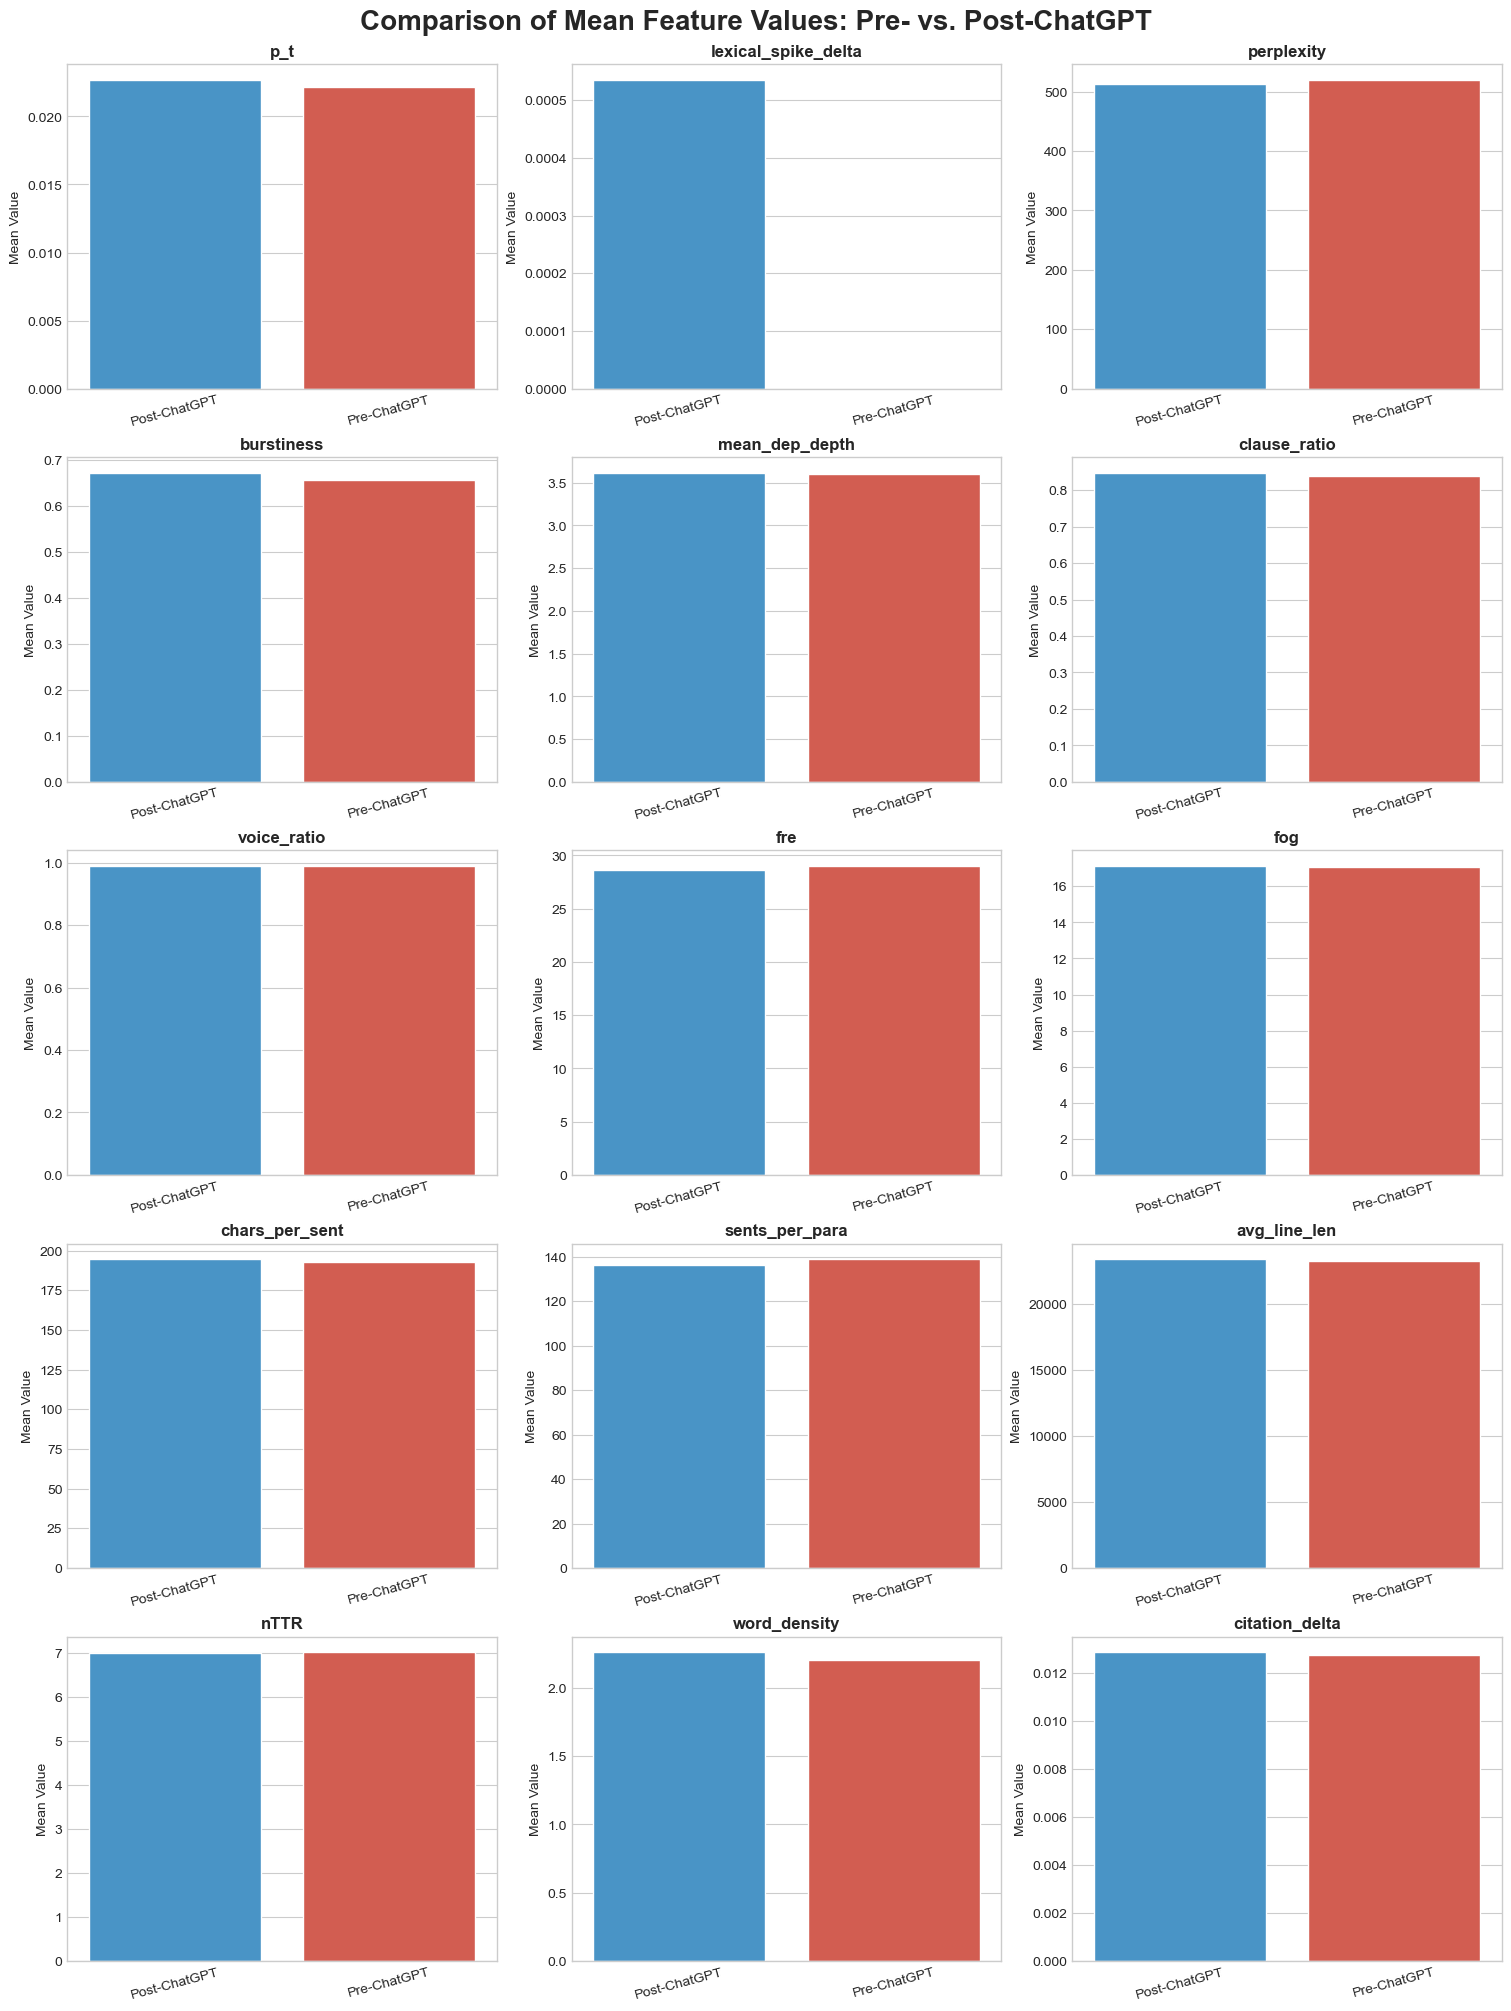

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_pre_post_comparison_faceted(df: pd.DataFrame, feature_cols: list[str], cutoff_date_str: str = '2022-11-01'):
    """
    Calculates the mean of features before and after a cutoff date and
    generates a readable facet grid of comparative bar plots.

    Args:
        df (pd.DataFrame): The DataFrame containing the data and a timestamp column.
        feature_cols (list[str]): A list of the raw feature columns to analyze.
        cutoff_date_str (str): The date string to use as the cutoff point.
    """
    print("--- Comparing Mean Feature Values: Pre- vs. Post-ChatGPT ---")

    # --- 1. Data Preparation ---
    df_work = df.copy()

    if not pd.api.types.is_datetime64_any_dtype(df_work['timestamp']):
        df_work['timestamp'] = pd.to_datetime(df_work['timestamp'], utc=True, errors='coerce')

    cutoff_date = pd.Timestamp(cutoff_date_str, tz='UTC')
    df_work['period'] = np.where(df_work['timestamp'] < cutoff_date, 'Pre-ChatGPT', 'Post-ChatGPT')

    # --- 2. Aggregation ---
    comparison_stats = df_work.groupby('period')[feature_cols].mean().reset_index()

    plot_data = pd.melt(
        comparison_stats,
        id_vars=['period'],
        value_vars=feature_cols,
        var_name='feature',
        value_name='mean_value'
    )

    print("\n--- Aggregated Mean Values ---")
    display(comparison_stats)

    # --- 3. Faceted Visualization ---
    # Dynamically determine the grid size
    n_features = len(feature_cols)
    n_cols = 3  # Set number of columns for the grid
    n_rows = math.ceil(n_features / n_cols)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create a separate plot for each feature
    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        feature_data = plot_data[plot_data['feature'] == feature]

        sns.barplot(
            data=feature_data,
            x='period',
            y='mean_value',
            ax=ax,
            palette=['#3498db', '#e74c3c'] # Blue for Pre, Red for Post
        )

        ax.set_title(feature, fontsize=12, weight='bold')
        ax.set_xlabel('') # Remove redundant x-axis label
        ax.set_ylabel('Mean Value', fontsize=10)
        ax.tick_params(axis='x', rotation=15)

    # Hide any unused subplots if the number of features is not a perfect multiple of n_cols
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)

    fig.suptitle('Comparison of Mean Feature Values: Pre- vs. Post-ChatGPT', fontsize=20, weight='bold')
    plt.show()


# --- Main Execution Block ---
# Assumes 'final_wiki_df' is the fully processed DataFrame from your Wikipedia analysis.

raw_features_to_plot = [
    'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness', 'mean_dep_depth',
    'clause_ratio', 'voice_ratio', 'fre', 'fog', 'chars_per_sent',
    'sents_per_para', 'avg_line_len', 'nTTR', 'word_density', 'citation_delta'
]
existing_features = [f for f in raw_features_to_plot if f in final_df.columns]

# Run the analysis and generate the faceted plot
plot_pre_post_comparison_faceted(final_df, existing_features)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_temporal_trend_with_means(file_path: str, timestamp_col: str = 'timestamp', flag_col: str = 'ai_flag'):
    """
    Loads flagged data, plots the monthly percentage of AI-flagged revisions,
    and adds horizontal lines showing the mean prevalence before and after
    the ChatGPT release.

    Args:
        file_path (str): The path to the input CSV file.
        timestamp_col (str): The name of the timestamp column.
        flag_col (str): The name of the boolean flag column.
    """
    print(f"--- Generating Temporal Trend Plot with Mean Shift from '{file_path}' ---")

    # --- 1. Load and Prepare Data ---
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df[timestamp_col] = pd.to_datetime(df[timestamp_col], utc=True, errors='coerce')
    df.dropna(subset=[timestamp_col], inplace=True)

    # --- 2. Calculate Pre- and Post-ChatGPT Means ---
    cutoff_date = pd.to_datetime('2022-11-30', utc=True)

    pre_period_df = df[df[timestamp_col] < cutoff_date]
    post_period_df = df[df[timestamp_col] >= cutoff_date]

    # Calculate the overall mean percentage for each period
    mean_pre = (pre_period_df[flag_col].mean()) * 100
    mean_post = (post_period_df[flag_col].mean()) * 100

    print("\n--- Mean Prevalence ---")
    print(f"Pre-ChatGPT (before {cutoff_date.date()}): {mean_pre:.2f}%")
    print(f"Post-ChatGPT (on/after {cutoff_date.date()}): {mean_post:.2f}%")

    # --- 3. Aggregate Data for Monthly Plot ---
    df.set_index(timestamp_col, inplace=True)
    monthly_prevalence = df[flag_col].resample('M').mean() * 100
    monthly_prevalence = monthly_prevalence.reset_index()
    monthly_prevalence.columns = ['month', 'ai_flag_percentage']

    # --- 4. Create the Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    sns.lineplot(data=monthly_prevalence, x='month', y='ai_flag_percentage', ax=ax,
                 linewidth=2.5, marker='o', markersize=6, label='Monthly % of AI-Flagged Revisions',
                 zorder=5)

    # --- 5. Add Mean Lines ---
    # Pre-ChatGPT Mean Line
    ax.axhline(y=mean_pre, color='#3498db', linestyle=':', linewidth=2.5,
               xmin=0.0, xmax=(cutoff_date - df.index.min()) / (df.index.max() - df.index.min()),
               label=f'Mean (Pre-ChatGPT) = {mean_pre:.2f}%')

    # Post-ChatGPT Mean Line
    ax.axhline(y=mean_post, color='#e74c3c', linestyle=':', linewidth=2.5,
               xmin=(cutoff_date - df.index.min()) / (df.index.max() - df.index.min()), xmax=1.0,
               label=f'Mean (Post-ChatGPT) = {mean_post:.2f}%')

    # Add the vertical release date line
    ax.axvline(x=cutoff_date, color='black', linestyle='--', linewidth=2,
               label='ChatGPT Public Release (Nov 2022)', zorder=10)

    # --- 6. Formatting and Labels ---
    plot_title = f'Prevalence of AI-Flagged Revisions on Wikipedia with Mean Shift with Z_SCORE_THRESHOLD = {Z_SCORE_THRESHOLD} and MINIMUM_VOTES = {MINIMUM_VOTES}'
    ax.set_title(plot_title, fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('Percentage of Revisions Flagged as AI (%)', fontsize=14)

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=12)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgray')
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()

In [1]:
# --- Main Execution Block ---
# Define the path to your final results file
# This file should be the output from your 'wiki_analysis_final.py' script
input_file = "normalized_everything100percat_with_ai_votes.csv"

plot_temporal_trend_with_means(input_file)


NameError: name 'plot_temporal_trend_with_means' is not defined

In [4]:
# read csv normalized_everything100percat_with_ai_votes.csv
df = pd.read_csv(input_file)
# print column names and their data types
print(df.dtypes)


Unnamed: 0                      int64
snapshot_ts                    object
rev_id                          int64
timestamp                      object
user                           object
is_bot                           bool
content                        object
article_id                      int64
title                          object
root                           object
stratum                        object
plain_text                     object
p_t                           float64
lexical_spike_delta           float64
perplexity                    float64
burstiness                    float64
upos_props                     object
mean_dep_depth                float64
clause_ratio                  float64
voice_ratio                   float64
fre                           float64
fog                           float64
chars_per_sent                float64
sents_per_para                float64
nTTR                          float64
word_density                  float64
avg_line_len

Generating Bar Chart of AI Prevalence by Topic...


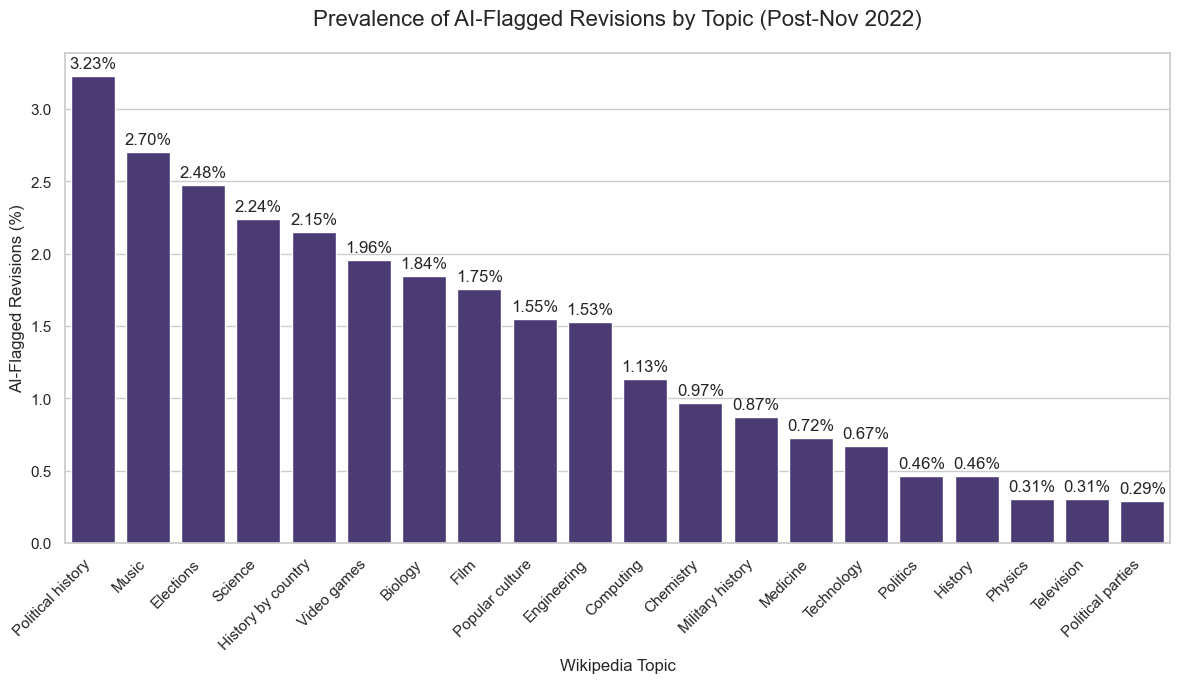


Generating Grouped Time Series Plot...


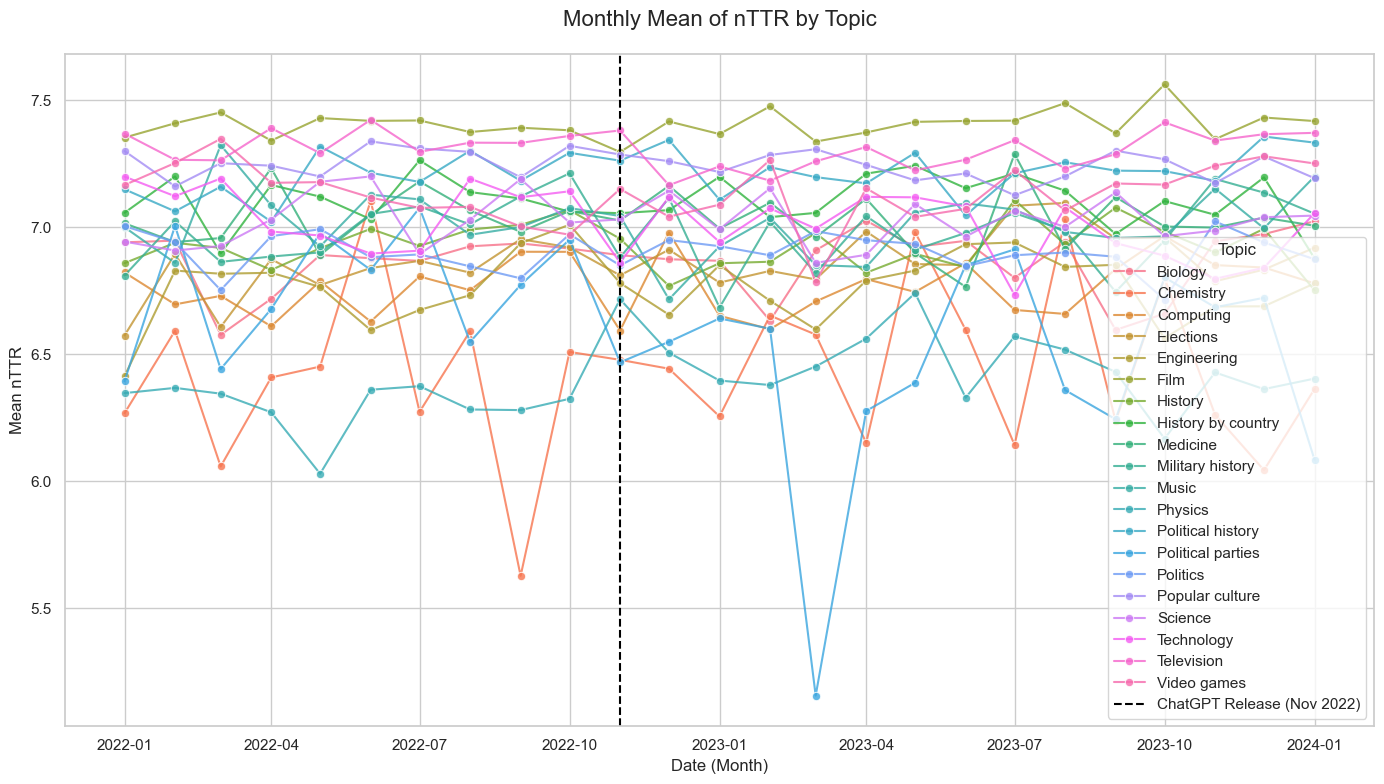

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Make sure numpy is imported for the dummy data fallback

# --- Step 1: Load and Prepare Your Data ---

pd.read_csv(input_file)
try:
    df = pd.read_csv(input_file)
except FileNotFoundError:
    print(f"Error: The file '{input_file}' was not found.")
    print("Please replace 'your_data.csv' with the correct path to your dataset.")


# --- Data Cleaning and Type Conversion ---
# This will correctly infer the UTC timezone from your data
df['snapshot_ts'] = pd.to_datetime(df['snapshot_ts'])

# --- THE FIX IS HERE ---
# Define the intervention date and make it timezone-aware to match the DataFrame
intervention_date = pd.to_datetime('2022-11-01', utc=True)

# Set a professional and appealing style for the plots
sns.set_theme(style="whitegrid", palette="viridis")


# --- Plot 1: Bar Chart of AI Prevalence by Topic (Post-Intervention) ---

print("Generating Bar Chart of AI Prevalence by Topic...")

# Filter for data after the intervention (this comparison will now work)
post_intervention_df = df[df['snapshot_ts'] >= intervention_date].copy()

# Group by the 'root' column (your topics) and calculate the mean of 'ai_flag'
prevalence_by_topic = post_intervention_df.groupby('root')['ai_flag'].mean().sort_values(ascending=False) * 100

# Create the bar plot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x=prevalence_by_topic.index, y=prevalence_by_topic.values)

# Add labels and title
plt.title('Prevalence of AI-Flagged Revisions by Topic (Post-Nov 2022)', fontsize=16, pad=20)
plt.xlabel('Wikipedia Topic', fontsize=12)
plt.ylabel('AI-Flagged Revisions (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.tight_layout()
plt.show()


# --- Plot 2: Grouped Time Series Plot for a Specific Feature ---

print("\nGenerating Grouped Time Series Plot...")

feature_to_plot = 'nTTR'

# Resample the data to get monthly averages for each topic
df_monthly_topic = df.groupby('root').resample('MS', on='snapshot_ts')[feature_to_plot].mean().reset_index()

# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_monthly_topic, x='snapshot_ts', y=feature_to_plot, hue='root', marker='o', alpha=0.8)

# Add a vertical line for the intervention date
plt.axvline(x=intervention_date, color='black', linestyle='--', label='ChatGPT Release (Nov 2022)')

# Add labels and title
plt.title(f'Monthly Mean of {feature_to_plot} by Topic', fontsize=16, pad=20)
plt.xlabel('Date (Month)', fontsize=12)
plt.ylabel(f'Mean {feature_to_plot}', fontsize=12)
plt.legend(title='Topic')

plt.tight_layout()
plt.show()


--- Generating Faceted Plot for 'nTTR' ---


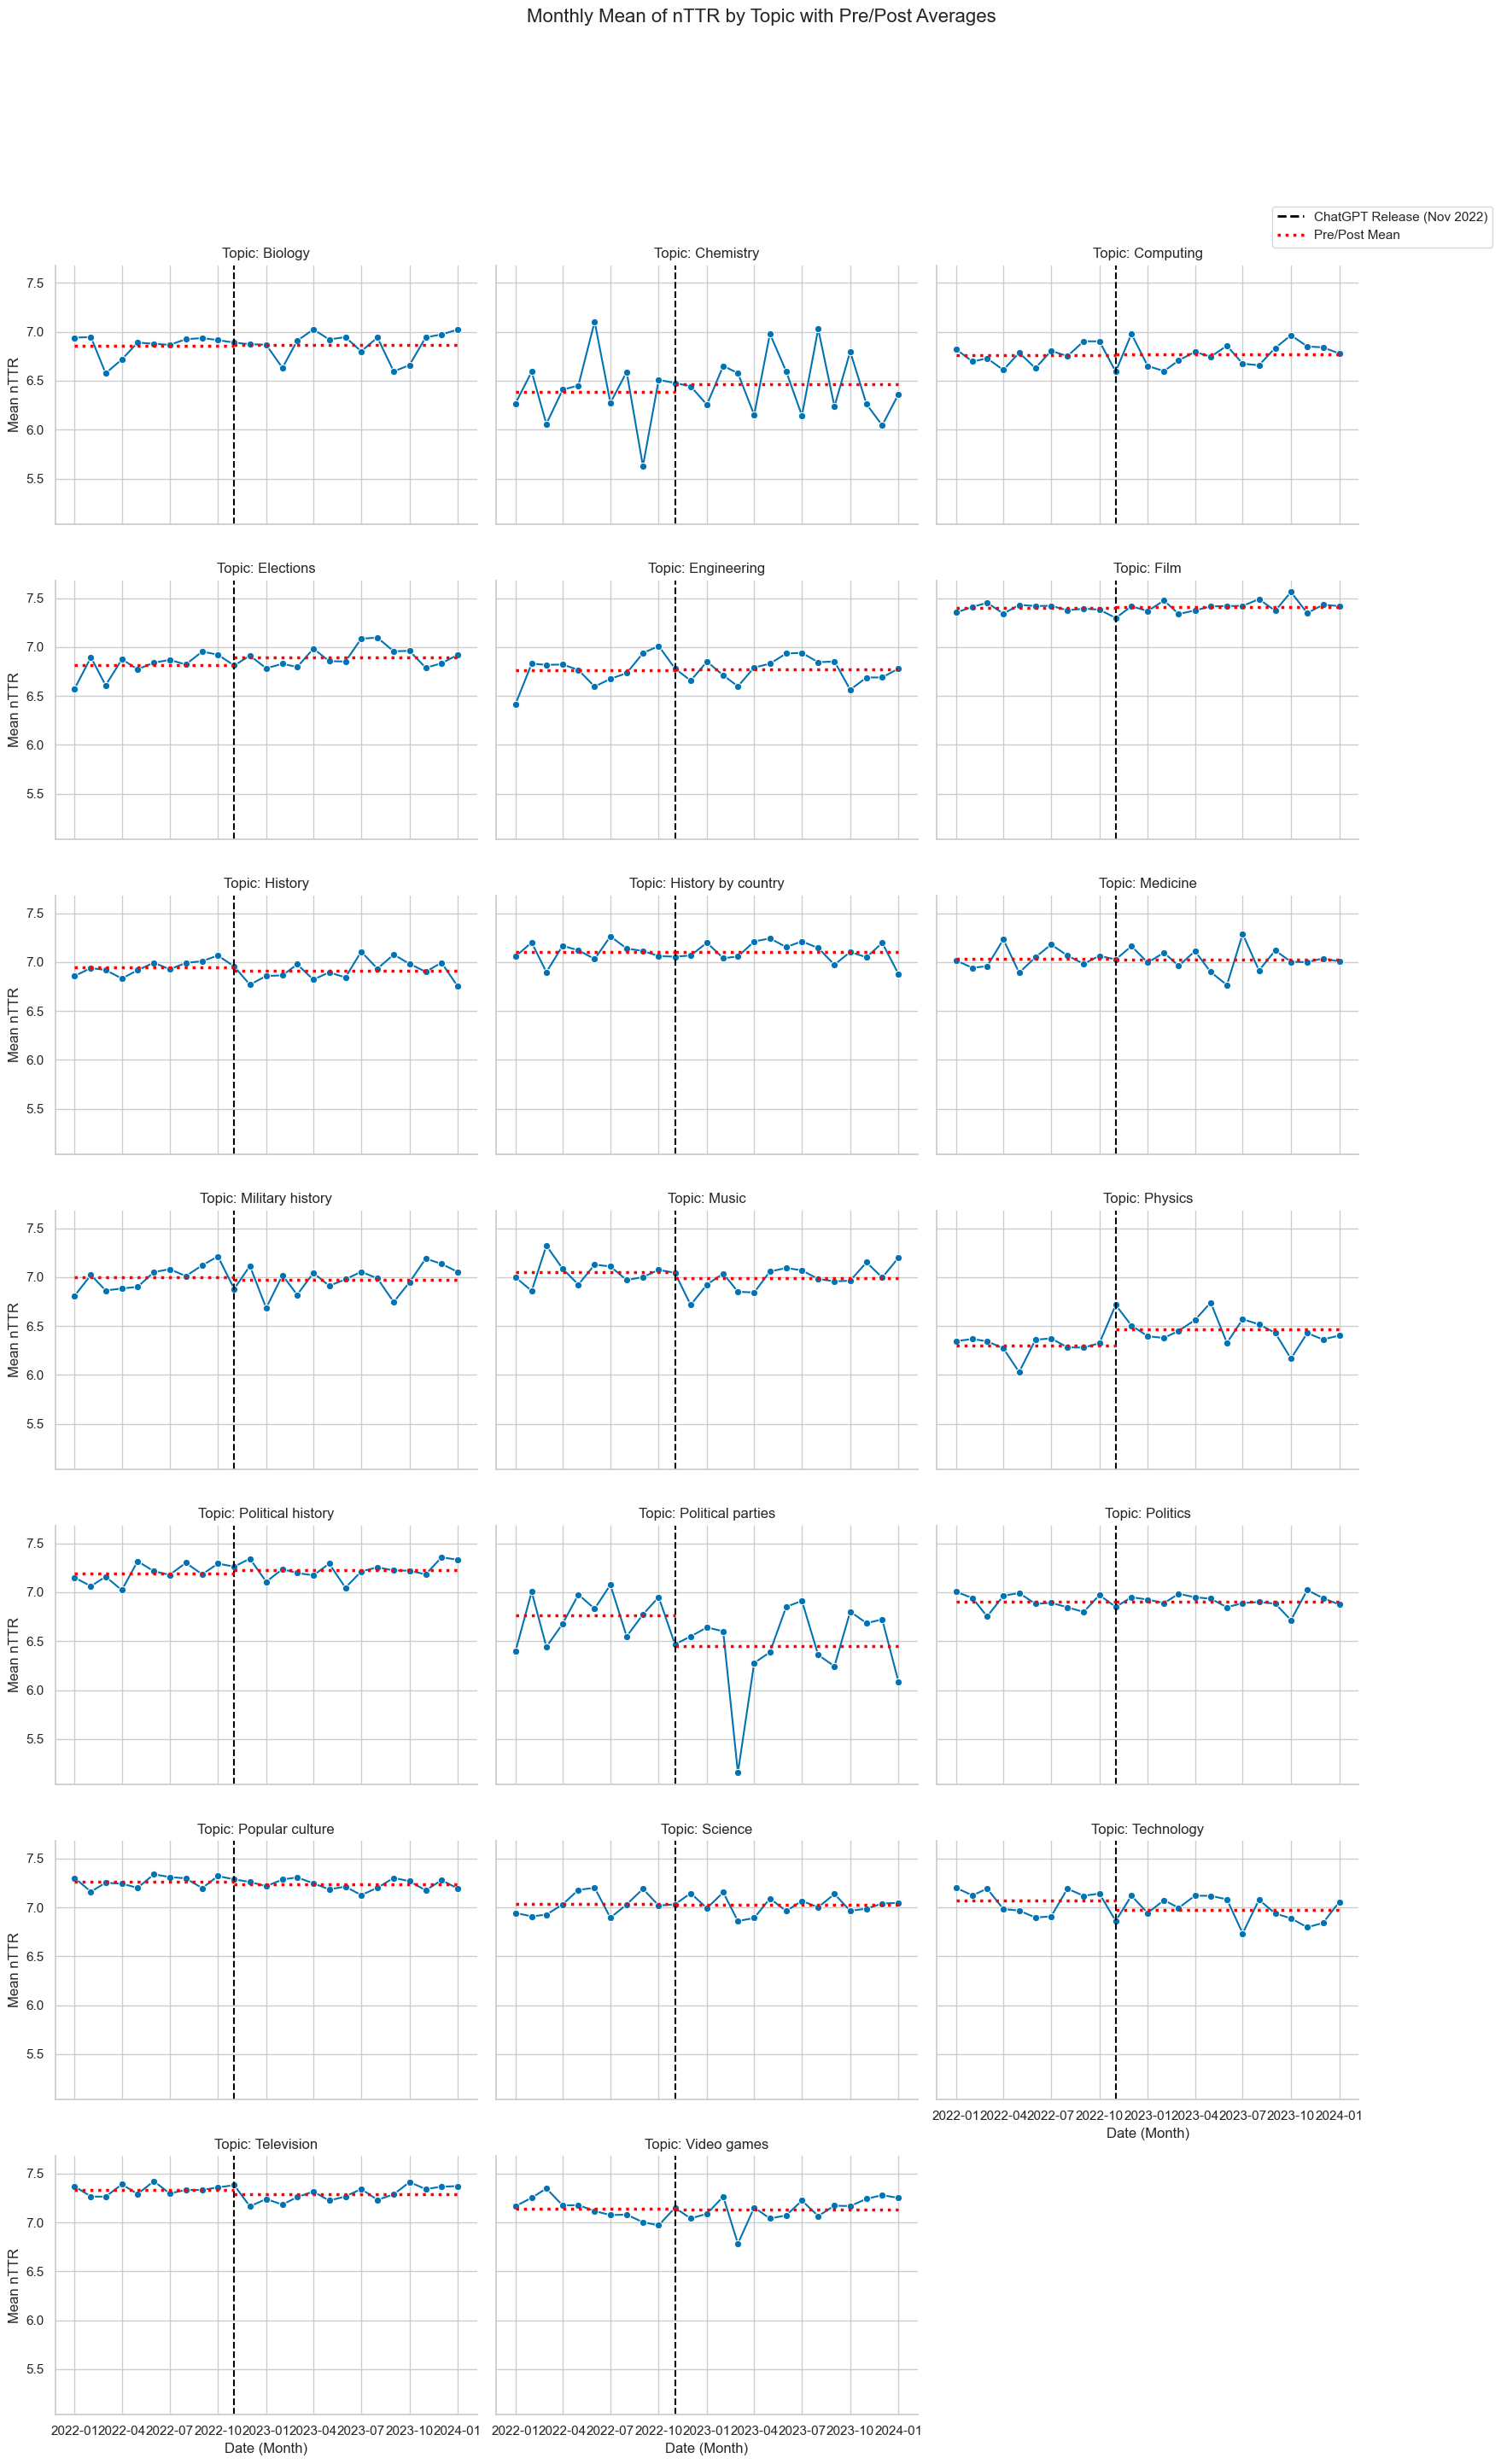


--- Textual Summary of Mean Values for 'nTTR' by Topic ---

Topic: Biology
  - Pre-Intervention Mean: 6.8596
  - Post-Intervention Mean: 6.8672
  - Absolute Change: 0.0076
  - Percentage Change: 0.11%

Topic: Chemistry
  - Pre-Intervention Mean: 6.3883
  - Post-Intervention Mean: 6.4674
  - Absolute Change: 0.0791
  - Percentage Change: 1.24%

Topic: Computing
  - Pre-Intervention Mean: 6.7639
  - Post-Intervention Mean: 6.7690
  - Absolute Change: 0.0051
  - Percentage Change: 0.08%

Topic: Elections
  - Pre-Intervention Mean: 6.8124
  - Post-Intervention Mean: 6.8969
  - Absolute Change: 0.0845
  - Percentage Change: 1.24%

Topic: Engineering
  - Pre-Intervention Mean: 6.7593
  - Post-Intervention Mean: 6.7668
  - Absolute Change: 0.0074
  - Percentage Change: 0.11%

Topic: Film
  - Pre-Intervention Mean: 7.3974
  - Post-Intervention Mean: 7.4093
  - Absolute Change: 0.0118
  - Percentage Change: 0.16%

Topic: History
  - Pre-Intervention Mean: 6.9453
  - Post-Intervention Mean: 6.9

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Load and Prepare Data (Same as before) ---
# TODO: Replace 'your_data.csv' with the actual path to your data file.
file_path = input_file
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Using dummy data for demonstration.")
    # Fallback with dummy data
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2024-12-31', freq='D'))
    topics = ['Technology', 'History', 'Science & Medicine', 'Popular Culture', 'Politics']
    data = []
    for date in dates:
        for topic in topics:
            is_post_intervention = date >= pd.to_datetime('2022-11-01')
            nttr = 7.0 + (topics.index(topic) * 0.05) - (0.1 if is_post_intervention else 0) + np.random.randn() * 0.05
            data.append({'snapshot_ts': date, 'root': topic, 'nTTR': nttr})
    df = pd.DataFrame(data)

df['snapshot_ts'] = pd.to_datetime(df['snapshot_ts'])
intervention_date = pd.to_datetime('2022-11-01', utc=True)
sns.set_theme(style="whitegrid", palette="colorblind")

# --- Step 2: Aggregate to Monthly Averages (Same as before) ---
# TODO: Change this to the feature you want to analyze (e.g., 'nTTR', 'voice_ratio')
feature_to_plot = 'nTTR'
df_monthly_topic = df.groupby('root').resample('MS', on='snapshot_ts')[feature_to_plot].mean().reset_index()

# --- Step 3: Create the Facet Grid Plot (Same as before) ---
print(f"--- Generating Faceted Plot for '{feature_to_plot}' ---")
g = sns.relplot(
    data=df_monthly_topic,
    x='snapshot_ts',
    y=feature_to_plot,
    col='root',
    col_wrap=3,
    kind='line',
    marker='o',
    height=4,
    aspect=1.5,
    legend=False
)

for topic, ax in g.axes_dict.items():
    ax.axvline(x=intervention_date, color='black', linestyle='--')
    topic_data = df_monthly_topic[df_monthly_topic['root'] == topic]
    pre_data = topic_data[topic_data['snapshot_ts'] < intervention_date]
    if not pre_data.empty:
        pre_mean = pre_data[feature_to_plot].mean()
        ax.hlines(y=pre_mean, xmin=pre_data['snapshot_ts'].min(), xmax=intervention_date, color='red', linestyle='dotted', linewidth=2.5)
    post_data = topic_data[topic_data['snapshot_ts'] >= intervention_date]
    if not post_data.empty:
        post_mean = post_data[feature_to_plot].mean()
        ax.hlines(y=post_mean, xmin=intervention_date, xmax=post_data['snapshot_ts'].max(), color='red', linestyle='dotted', linewidth=2.5)

g.fig.suptitle(f'Monthly Mean of {feature_to_plot} by Topic with Pre/Post Averages', fontsize=16, y=1.03)
g.set_axis_labels('Date (Month)', f'Mean {feature_to_plot}')
g.set_titles("Topic: {col_name}")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='ChatGPT Release (Nov 2022)'),
    Line2D([0], [0], color='red', lw=2.5, linestyle='dotted', label='Pre/Post Mean')
]
g.fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
g.tight_layout(w_pad=1, rect=[0, 0, 0.9, 0.95])
plt.show()


# --- Step 4: Calculate and Print Textual Summary of Means ---
print(f"\n--- Textual Summary of Mean Values for '{feature_to_plot}' by Topic ---")

# Get the unique list of topics to iterate through
all_topics = df_monthly_topic['root'].unique()

for topic in all_topics:
    # Filter data for the specific topic
    topic_data = df_monthly_topic[df_monthly_topic['root'] == topic]

    # Calculate pre-intervention mean
    pre_data = topic_data[topic_data['snapshot_ts'] < intervention_date]
    pre_mean = pre_data[feature_to_plot].mean()

    # Calculate post-intervention mean
    post_data = topic_data[topic_data['snapshot_ts'] >= intervention_date]
    post_mean = post_data[feature_to_plot].mean()

    # Calculate the change
    if pre_mean != 0:
        change = post_mean - pre_mean
        percent_change = (change / pre_mean) * 100
    else:
        change = 0
        percent_change = 0

    # Print the formatted output
    print(f"\nTopic: {topic}")
    print(f"  - Pre-Intervention Mean: {pre_mean:.4f}")
    print(f"  - Post-Intervention Mean: {post_mean:.4f}")
    print(f"  - Absolute Change: {change:.4f}")
    print(f"  - Percentage Change: {percent_change:.2f}%")


